# Next Steps:

1. Re-run everything with 24 fps instead of 1 fps and explore the filtering process more, measuring false positive and false negative rates
2. Blur out timestamps 
3. Get data augmentation working
4. Try better architectures e.g. ResNet and Inception and increase the resolution of the input image (we're rescaling to 224x224 but the input frames are bigger)
5. Try an ensamble of different architectures
6. Incorporate the time dimension of the video using an LSTM on top of the sequence of convolutional frame representations
7. Annotate bounding boxes and then predict bounding boxes using F-RCNN before classifying content of the bounding boxes
8. Label more training data


...

See here for other architectures:

https://keras.io/applications/

https://github.com/fchollet/deep-learning-models/releases

# Setup

## imports

In [108]:
from keras import backend as K
K.set_image_dim_ordering('th')
#
from keras.callbacks import ModelCheckpoint
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [109]:
# for VGG
from keras.applications.vgg16 import preprocess_input

In [148]:
from skimage.transform import resize

In [3]:
# For annotating frames to create output
from PIL import Image as PIL_Image
from PIL import ImageFont
from PIL import ImageDraw 

for plotting and misc

In [4]:
# setup matplotlib to display plots in the notebook
%matplotlib inline

# third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setup display options
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:,.5g}'.format
np.set_printoptions(precision=5, suppress=False)

# setup seaborn to use matplotlib defaults & styles
sns.set()
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})

import os
import sys
import time

turn off jupyter notebook keras warnings

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

## image size

In [6]:
# dimensions of our images.
img_width, img_height = 224, 224

## paths

In [7]:
pwd = '/mnt/data/seals/'

path_models = pwd + 'models/'
# for previewing data augmentation output:
path_preview = pwd + 'data/preview/' 

path_data = pwd + 'data/images/'
#path_data = pwd + 'data/images_blurred/'

path_data_train = path_data +'train/'
path_data_valid = path_data +'valid/'
path_data_test = path_data +'test/'
# output
path_data_train, path_data_valid, path_data_test

In [11]:
print ('train: #seal =', len(os.listdir(path_data_train + '/seal/')), '#noseal = ', len(os.listdir(path_data_train + '/noseal/')))
print ('valid: #seal =', len(os.listdir(path_data_valid + '/seal/')), '#noseal = ', len(os.listdir(path_data_valid + '/noseal/')))

train: #seal = 1175 #noseal =  1176
valid: #seal = 167 #noseal =  123


In [12]:
path_frames = pwd + 'data/frames/'
path_frames_annotated = pwd + 'data/frames_annotated/'

directory structure shown below - NB I manually (approximately) balanced the train seal and noseal classes

In [13]:
!tree -d /mnt/data/seals/

/mnt/data/seals/
├── data
│   ├── frames
│   ├── frames_annotated
│   ├── frames_annotated_filter_1
│   ├── frames_annotated_filter_2
│   ├── images
│   │   ├── preview
│   │   ├── test
│   │   │   ├── noseal
│   │   │   └── seal
│   │   ├── train
│   │   │   ├── noseal
│   │   │   └── seal
│   │   └── valid
│   │       ├── noseal
│   │       └── seal
│   ├── images_blurred
│   │   ├── preview
│   │   ├── test
│   │   │   ├── noseal
│   │   │   └── seal
│   │   ├── train
│   │   │   ├── noseal
│   │   │   └── seal
│   │   └── valid
│   │       ├── noseal
│   │       └── seal
│   ├── models
│   ├── output
│   ├── preview
│   └── videos
├── models
└── notebooks

33 directories


# View some of the data

In [14]:
def plotimg(imgpath):
    img= plt.imread(imgpath)
    imgplot = plt.imshow(img)

In [15]:
def plot_pic_grid(path, filenames, add_title=True):
    # set figsize
    fig = plt.figure()
    fig.set_size_inches((16,8))

    plotted = 0

    for c, r in enumerate(filenames):

        # get path to image file 
        img_path_on_disk = path + r

        if len(img_path_on_disk) > 0:    

            if plotted < 10:

                plotted+=1

                # plotting 10 images
                a = fig.add_subplot(2, 5, (plotted))
                img= plt.imread(img_path_on_disk)
                imgplot = a.imshow(img)
                if add_title: 
                    a.set_title(r)

                #print user_id, 'image plotted'
        else:
            # print user_id, 'no pic available'
            pass

> SEAL

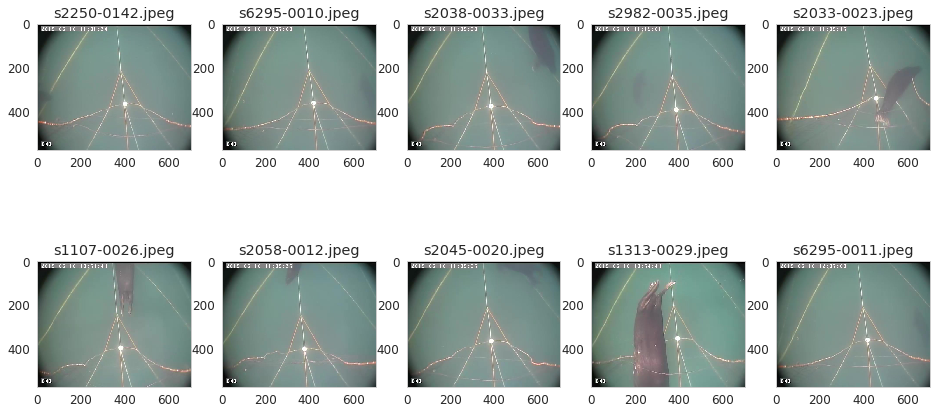

In [16]:
plot_pic_grid(path_data +'train/seal/', os.listdir(path_data +'train/seal/')[:10])

> NOSEAL

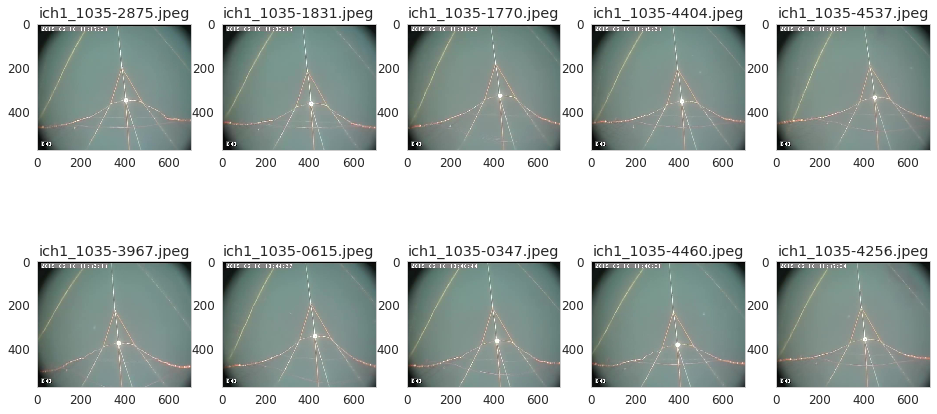

In [17]:
plot_pic_grid(path_data +'train/noseal/', os.listdir(path_data +'train/noseal/')[:10])

# Prepare Data

## Create train/test split

> only run the below once - it creates the train / valid / test splits

In [18]:
import random

create_train_test = False

# define val & test split sizes
val_pct = 0.15
test_pct = 0.001

# move (val_pct)% of each class from train to validation folder
# move (test_pct)% of each class from train to test folder

if create_train_test:
    
    # first get list of subdirectories (these are the image class names)
    folders = os.listdir(path_data_train)
    
    # remove .DS_Store artefact - just want actual class names in list
    folders = [f for f in folders if not f.startswith('.')]
               
    for fo in folders:
        print (fo, len(folders))
        
        files = os.listdir(path_data_train + fo)
        files = [fi for fi in files if not fi.startswith('.')]

        # create class folder in /data/valid/ if doesn't already exist
        if not os.path.exists(path_data_valid + fo):
            os.makedirs(path_data_valid + fo)
        
        train_count = len(files)
        val_count = int(train_count * val_pct)
        test_count = int(train_count * test_pct / len(folders)) #uniformly sample for test

        # > move validation
        print ('move valid')
        # select random val_pct% subset of images in this class and move to validation path
        subset = random.sample(files, val_count)
        #
        for s in subset:
            os.rename(path_data_train + fo + "/" + s, path_data_valid + fo + "/" + s)
               
        # > move test 
        print ('move test')
        files = os.listdir(path_data_train + fo)
        subset = random.sample(files, test_count)
        #
        for s in subset:
            os.rename(path_data_train + fo + "/" + s, path_data_test + "unknown/" + s)
    
    print ('done')

In [19]:
# Delete percent of files in folder 
def delete_pct_files_in_folder(target_folder, delete_pct = 0.9):

    # get files in folder
    files = os.listdir(target_folder)
    files = [fi for fi in files if not fi.startswith('.')]
    files = [target_folder + '/' + f for f in files]

    # get count of files to delete
    delete_count = int(len(files) * delete_pct)

    # get subset
    subset = random.sample(files, delete_count)

    # delete files in subset
    for s in subset:
        if not os.path.isdir(s):
            os.remove(s)

In [20]:
create_sample = False

# keep 10% of images in each folder
sample_pct = 0.1

if create_sample:
    for root, subdirs, files in os.walk(path_data_sample):
        print (root)
        delete_pct_files_in_folder(root, 1 - sample_pct)

In [21]:
! echo 'train'
! ls -la $path_data_train/seal | wc -l
! ls -la $path_data_train/noseal | wc -l
! echo 'valid'
! ls -la $path_data_valid/seal | wc -l
! ls -la $path_data_valid/noseal | wc -l
! echo 'test'
! ls -la $path_data_test/seal | wc -l
! ls -la $path_data_test/noseal | wc -l

train
1178
1179
valid
170
126
test
339
1637


## blur timestamps

### define function to blur images and show result

In [27]:
def blur_timestamp(image_path):
    
    # read image
    image = cv2.imread(image_path)
    result_image = image.copy()

    # rectangle to blur
    x = 0
    y = 0
    w = 700
    h = 35

    # https://stackoverflow.com/questions/18064914/how-to-use-opencv-python-to-blur-faces
    # get the rectangle img around all the faces
    cv2.rectangle(image, (x,y), (x+w,y+h), (255,255,0), 0)
    blurred_rect = image[y:y+h, x:x+w]
    # apply a gaussian blur on this new recangle image
    blurred_rect = cv2.GaussianBlur(blurred_rect,(0, 0), 25)
    # merge this blurry rectangle to our final image
    result_image[y:y+blurred_rect.shape[0], x:x+blurred_rect.shape[1]] = blurred_rect
    
    return result_image
    #cv2.imwrite(pwd + '/data/images_blurred/blurred.jpg', result_image)

In [28]:
image_path = path_data_train + 'seal/' + os.listdir(path_data_train + 'seal')[0]
image_path

'/mnt/data/seals/data/images/train/seal/s2250-0142.jpeg'

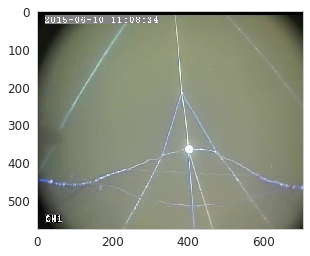

In [29]:
import cv2
image = cv2.imread(image_path)
plt.imshow(image)

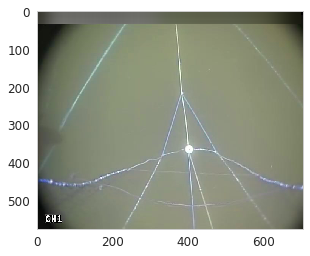

In [30]:
image = blur_timestamp(image_path)
plt.imshow(image)

### blur all images and save results

I first copied all images in /data/images/ to /data/images_blurred/ - the code below overwrites the copied images with blurred versions

In [ ]:
do_blur = True

if do_blur:
    # get all image files
    all_files = []
    for path, subdirs, files in os.walk(path_data):
        for name in files:
            all_files.append(os.path.join(path, name))

    # apply blur to each file
    for c, file in enumerate(all_files):

        #print (c, file.replace('images','images_blurred'))

        blurred_image = blur_timestamp(file)

        cv2.imwrite(file.replace('images','images_blurred'), blurred_image)

        if c % 100 == 0:
            print(c,len(all_files))

> NB re-run paths code at the top to get the train/valid etc but now with path_data = /data/images_blurred/ 

timestamps now blurred

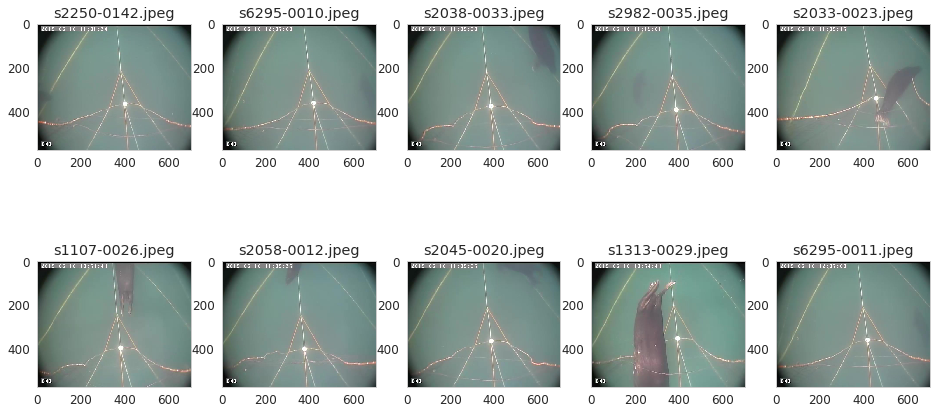

In [31]:
plot_pic_grid(path_data +'train/seal/', os.listdir(path_data +'train/seal/')[:10])

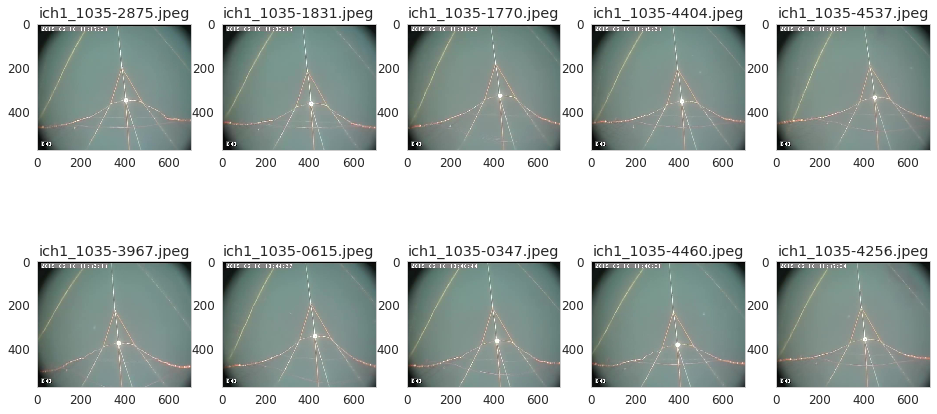

In [32]:
plot_pic_grid(path_data +'train/noseal/', os.listdir(path_data +'train/noseal/')[:10])

## extract frames from video

> convert the video from avi to mp4 using ffmpeg 
* https://stackoverflow.com/questions/15057151/installing-ffmpeg-on-amazon-linux-cpp-gcc-libstdc-dependancies
* https://stackoverflow.com/questions/39808290/opencv-python-videocapture-only-loads-part-of-video
    

In [ ]:
# first install ffmpeg:
# !sudo apt install ffmpeg

In [ ]:
# run the script below in terminal to extract frames
# !ffmpeg -i ch1_1035.mp4 -vf fps=1 out%0d.png

> NB - I'm currently doing 1 FPS but we should really do 24 FPS

# Fit VGG Model

We don't have a lot of data so we'll use a pre-trained convolutional. 

This pre-trained network was built to predict which of 1000 ImageNet classes a particular image belongs to so the weights and convolutional filters are able to detect a wide variety of shapes and patterns. 

We'll then chop off the final dense layers and keep only the pre-trained convolutional layers ("bottleneck features"). 

Next, we'll create our own final layers and train just these final layers for our task...

## Setup number of samples

In [33]:
nb_train_approved = len(os.listdir(path_data_train + '/seal/'))
nb_train_rejected = len(os.listdir(path_data_train + '/noseal/'))
#
nb_valid_approved = len(os.listdir(path_data_valid + '/seal/'))
nb_valid_rejected = len(os.listdir(path_data_valid + '/noseal/'))
#
nb_train_samples = nb_train_approved + nb_train_rejected
nb_valid_samples = nb_valid_approved + nb_valid_rejected
#
print ("train: {} ... approved: {} rejected: {}".format(nb_train_samples, nb_train_approved, nb_train_rejected))
print ("valid: {} ... approved: {} rejected: {}".format(nb_valid_samples, nb_valid_approved, nb_valid_rejected))      

train: 2351 ... approved: 1175 rejected: 1176
valid: 290 ... approved: 167 rejected: 123


* NB * number of train and valid samples needs to be divisible by batch_size because of generators

## Instantiate pre-trained VGGNet and load weights

https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069

In [35]:
# https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

Download pre-trained weights

In [36]:
# run the command line function below to download pre-trained VGG weights:
# !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5

In [37]:
path_pretrained_vgg = '/mnt/data/NSFW/ml_image_moderation_training/pretrained_weights/vgg16_weights_th_dim_ordering_th_kernels.h5'

load pretrained weights

In [38]:
model.load_weights(path_pretrained_vgg)

In [39]:
# pop layers until just have the bottleneck max pooling 512,7,7 layer
for i in range(0,6):
    model.layers.pop()
    
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []

model.compile(optimizer='rmsprop', loss='binary_crossentropy')

> notice now the final layer of the network is the 512 x 7 x 7 bottleneck layer

## Precompute bottleneck outputs for train and validation data

> We precompute the bottleneck features since that's where most of the computation time is - once we've precomputed them, we'll just learn the weights on final layer(s) added on top of the bottleneck features but if we didn't precompute them, we'd have to compute them each time we pass an image through the entire network even though we're only learning weights on the final layer. 

create generators

In [118]:
# x = 3D tensor version
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [119]:
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255, 
                             preprocessing_function=preprocess_input)

In [120]:
train_generator_bottleneck = datagen.flow_from_directory(
        path_data_train,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 2351 images belonging to 2 classes.


In [121]:
validation_generator_bottleneck = datagen.flow_from_directory(
        path_data_valid,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 290 images belonging to 2 classes.


In [ ]:
# get mapping
mapping = train_generator_bottleneck.class_indices
mapping_inv = {v: k for k, v in mapping.items()}
mapping_inv

precompute bottleneck features

In [126]:
path_models

'/mnt/data/seals/models/'

In [127]:
### BOTTLENECK FEATURES: TRAIN 
if os.path.exists(path_models + 'seals_bottleneck_features_train.npy'):
    print("opening previously computed bottleneck features from file: TRAIN")
    train_data = np.load(open(path_models + 'seals_bottleneck_features_train.npy', 'rb'))
else:
    print("Computing bottleneck features: TRAIN")
    train_data = model.predict_generator(train_generator_bottleneck, train_generator_bottleneck.n, verbose = 1)
    np.save(open(path_models + 'seals_bottleneck_features_train.npy', 'wb'), train_data)

# split out labels
train_labels = np.array([(1,0)] * nb_train_approved + [(0,1)] * nb_train_rejected)

Computing bottleneck features: TRAIN
2351/2351 [==============================] - 72s    


In [128]:
### BOTTLENECK FEATURES: VALIDATION
if os.path.exists(path_models + 'seals_bottleneck_features_validation.npy'):
    print("opening previously computed bottleneck features from file: VALIDATION")
    validation_data = np.load(open(path_models + 'seals_bottleneck_features_validation.npy', 'rb'))
else:
    print("Computing bottleneck features: VALIDATION")
    validation_data = model.predict_generator(validation_generator_bottleneck, validation_generator_bottleneck.n, verbose = 1)
    np.save(open(path_models + 'seals_bottleneck_features_validation.npy', 'wb'), validation_data)

# split out labels
validation_labels = np.array([(1,0)] * nb_valid_approved + [(0,1)] * nb_valid_rejected)

Computing bottleneck features: VALIDATION
289/290 [============================>.] - ETA: 0s

## Add new final layer(s)

add fully connected layers (on top of bottleneck convolutional layers)

In [129]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax'))

I tried a bunch of optimizers and got the highest val_acc on VGG with adadelta, near runner up was adam

In [130]:
model_top.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Learn weights on new final layer(s)

In [131]:
model_name = 'seals_VGG'

In [137]:
model_name

'seals_VGG'

In [139]:
# load weights / train model
if os.path.exists(path_models + model_name + '_BEST_.hdf5'):
    print("loading pretrained weights: {}".format(model_name))
    model_top.load_weights(path_models + model_name + '_BEST_.hdf5')    
else:
    print("training model: {}".format(model_name))

    nb_epoch = 100
    
    # define keras model checkpointer to save best model (highets val_acc)
    checkpointer = ModelCheckpoint(path_models + model_name + '_BEST_.hdf5', 
                                    monitor='val_acc', 
                                    save_best_only=True,
                                    save_weights_only=True)

    # fit model, storing history in variable to plot learning curves
    history = model_top.fit(train_data, 
                    train_labels,
                    nb_epoch=nb_epoch, 
                    batch_size=32,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[checkpointer])

loading pretrained weights: seals_VGG


In [141]:
# fit model, storing history in variable to plot learning curves
history = model_top.fit(train_data, 
                train_labels,
                nb_epoch=nb_epoch, 
                batch_size=32,
                validation_data=(validation_data, validation_labels),
                callbacks=[checkpointer])

Train on 2351 samples, validate on 290 samples
Epoch 1/50
2351/2351 [==============================] - 1s - loss: 0.5731 - acc: 0.6810 - val_loss: 0.7378 - val_acc: 0.6897
Epoch 2/50
2351/2351 [==============================] - 0s - loss: 0.5819 - acc: 0.6670 - val_loss: 0.7796 - val_acc: 0.7621
Epoch 3/50
2351/2351 [==============================] - 0s - loss: 0.5773 - acc: 0.6750 - val_loss: 0.7810 - val_acc: 0.7414
Epoch 4/50
2351/2351 [==============================] - 0s - loss: 0.5528 - acc: 0.7129 - val_loss: 0.7876 - val_acc: 0.7897
Epoch 5/50
2351/2351 [==============================] - 0s - loss: 0.5544 - acc: 0.7116 - val_loss: 0.7960 - val_acc: 0.7586
Epoch 6/50
2351/2351 [==============================] - 0s - loss: 0.5732 - acc: 0.6814 - val_loss: 0.7094 - val_acc: 0.7276
Epoch 7/50
2351/2351 [==============================] - 0s - loss: 0.5701 - acc: 0.6806 - val_loss: 0.7126 - val_acc: 0.7690
Epoch 8/50
2351/2351 [==============================] - 0s - loss: 0.6001 - ac

## Plot learning curves

In [142]:
def plot_learning_curves(history):
    
    # create fig and set size
    fig = plt.figure()
    fig.set_size_inches((16,8))
    #
    f_rowz, f_colz = 1,2
    f_plt_idx = 0
    
    # plot accuracy 
    f_plt_idx += 1 
    a = fig.add_subplot(f_rowz, f_colz , (f_plt_idx))
    #
    a.plot(history.history['acc'])
    a.plot(history.history['val_acc'])
    a.set_title('model accuracy')
    a.set_ylabel('accuracy')
    a.set_xlabel('epoch')
    a.legend(['training', 'validation'], loc='upper left')
    
    # plot loss
    f_plt_idx += 1
    a = fig.add_subplot(f_rowz, f_colz , (f_plt_idx))
    #
    a.plot(history.history['loss'])
    a.plot(history.history['val_loss'])
    a.set_title('model loss')
    a.set_ylabel('loss')
    a.set_xlabel('epoch')
    a.legend(['training', 'validation'], loc='upper left') 

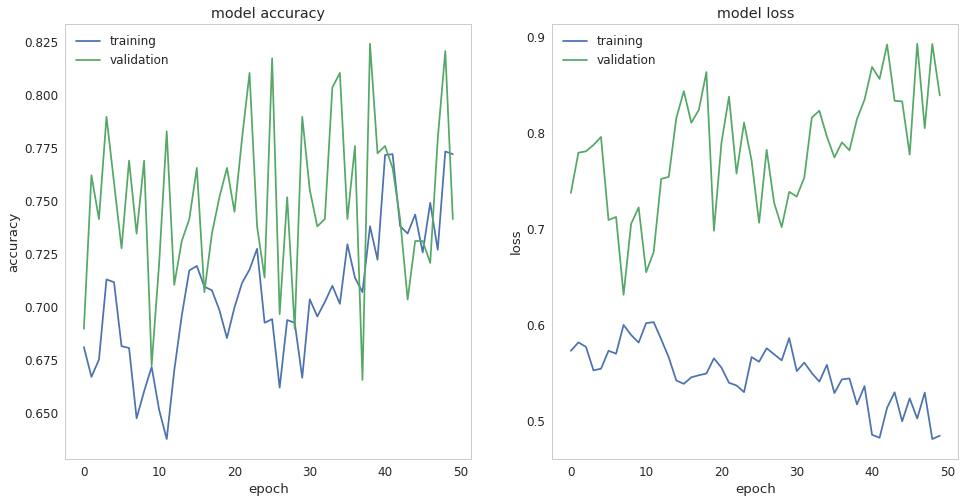

In [143]:
# may have loaded previous model and then history undefined
try:
    plot_learning_curves(history)
except:
    pass

In [144]:
# load weights from best epoch (saved by checkpointer)
model_top.load_weights(path_models + 'seals_VGG_BEST_.hdf5')

In [146]:
# check metrics for this best model
print (model_top.metrics_names)
model_top.evaluate(validation_data, validation_labels, verbose = 1)

['loss', 'acc']
 32/290 [==>...........................] - ETA: 0s

[0.81477086693048473, 0.82413793103448274]

# Predict frames

## Define function to do prediction

In [147]:
# img_path = path_data + '/train/seal/' + os.listdir(path_data + '/train/seal')[0]

In [ ]:
mapping_inv

In [233]:
img = Image.open(img_path)
img = img.resize((224,224))
image_array = np.array(img)[:, :, 0:3].astype(float)
image_array = preprocess_input(image_array)
image_array = np.moveaxis(image_array, -1, 0)
image_array = np.expand_dims(image_array, axis=0)

In [ ]:
# get activations
pred_activations = model.predict([image_array])

In [ ]:
model_top.predict(pred_activations)

In [247]:
# Need to get bottleneck features from model 
# then feed these to model_top to do actual prediction
def get_prediction(img_path, return_probabilities = False):
    
    img = Image.open(img_path)
    img = img.resize((224,224))
    image_array = preprocess_input(np.array(img).astype(float))
#     image_array = img[:, :, 0:3]
    image_array = preprocess_input(image_array)
    image_array = np.moveaxis(image_array, -1, 0)
    image_array = np.expand_dims(image_array, axis=0)

    # get activations
    pred_activations = model.predict([image_array])
    
    out = model_top.predict(pred_activations)
    
    if return_probabilities:
        return out
    else:
        print (mapping_inv[np.argmax(out)])
        return np.argmax(out)

View probability outputs for some images

In [246]:
predz = []
for path in [path_data +'valid/seal/' + f for f in os.listdir(path_data +'valid/seal/')][0:5]:
    predz.append(get_prediction(path,True))
predz

TypeError: 'Image' object is not subscriptable

In [238]:
predz = []
for path in [path_data +'valid/noseal/' + f for f in os.listdir(path_data +'valid/noseal/')][0:5]:
    predz.append(get_prediction(path,True))
predz

[array([[ 0.,  1.]], dtype=float32),
 array([[ 0.,  1.]], dtype=float32),
 array([[ 0.,  1.]], dtype=float32),
 array([[ 0.,  1.]], dtype=float32),
 array([[ 0.,  1.]], dtype=float32)]

Define function to plot predictions to verify order of probabilities

In [83]:
def plot_prediction(img_path):
    x = get_prediction(img_path, True)
    img= plt.imread(img_path)
    imgplot = plt.imshow(img)
    plt.title(x)
    plt.suptitle(img_path)

Plot images from each class to determine order of probabilities returned

...

First number is noseal and second number is seal - so if we argmax the probabilities array, we'll get 0 for noseal and 1 for seal.

In [84]:
plot_prediction(path_data +'train/seal/' + os.listdir(path_data +'train/seal/')[40])

TypeError: open() got an unexpected keyword argument 'target_size'

In [ ]:
plot_prediction(path_data +'train/noseal/' + os.listdir(path_data +'train/noseal/')[12])

## Predict frames

In [ ]:
all_frames = [path_frames + f for f in os.listdir(path_frames)]
print("Number of frames to annotate: {}".format(len(all_frames)))

In [ ]:
# create list of dicts with filename and prediction
prediction_results = []

In [ ]:
for c, path_frame in enumerate(all_frames):
    
    # create dict to add to list of results
    result_dict = {}
    result_dict['filename'] = path_frame
    result_dict['prediction'] = get_prediction(path_frame)
    
    # add to results
    prediction_results.append(result_dict)
    
    # update progress every 10% done
    if c % (len(all_frames) // 10) == 0:
        print ("{}/{}".format(c,len(all_frames)))

In [ ]:
# convert to dataframe
prediction_results = pd.DataFrame(prediction_results)

In [ ]:
prediction_results.to_csv(path_models + 'prediction_results.csv')

# Annotate Frames

> Define function to annotate frames given a prediction_results dataframe... because just annotating the raw results produces a noisy output with single frames sometimes showing 'Seal' when it's just a prediction error - we'll try filtering single frame predictions out and see if that improves the results

> Note we'll also pad the output frames' names with 0s so that they all have the same number of digits in the name as required to merge the frames back into a video with ffmpeg

In [76]:
def annotate_frames(prediction_results_dataframe, output_folder = 'frames_annotated'):
    
    for c, frame in enumerate(prediction_results_dataframe.values):
    
        # separate fields from this row of the prediction_results dataframe
        frame_filename = frame[0]
        frame_label = frame[1]

        # open the original frame
        img = PIL_Image.open(frame_filename)
        draw = ImageDraw.Draw(img)

        font = ImageFont.truetype("/mnt/data/seals/sourcesans.ttf", 45)

        if frame_label == 0:
            draw.text((50, 50),"> NOSEAL" ,(255,255,255),font=font)
        else:
            draw.text((50, 50),"> SEAL",(0,255,0),font=font)

        # 0-pad the file name so that we can use ffmpeg later to recombine the frames into a video
        img.save(path_frames.replace('frames',output_folder) + pad_filename(frame_filename.split("/").pop()))

        # update progress every 10% done
        if c % (len(all_frames) // 10) == 0:
            print ("{}/{}".format(c,len(all_frames)))

## Annotate frames with raw prediction results

In [ ]:
annotate_frames(prediction_results, 'frames_annotated')

# Filter out single frames

> The output of annotating frames with the raw prediction results is quite noisy so I tried applying some filters. For example, if a frame that predicts seal is not followed by another frame wiht a seal then treat it as noise as make it 'noseal' (in the case of a 1 period filter or no less than 3 consecutive seal predictions for a 2 period filter). 

This does seem to improve the output but I haven't measured the improvement. 

Also note I'm working at 1 FPS frame extractions but this should be done with 24 FPS frame extractions and then adjusted period filters...

## Prepare prediction results (sort them)

In [ ]:
pr_filtered = prediction_results.copy()

In [ ]:
# sort
pr_filtered['file_id'] = pr_filtered['filename'].str.split("out").str.get(1).str.split('.png').str.get(0).astype(int)
pr_filtered.sort_values('file_id',inplace=True)
pr_filtered.index = pr_filtered['file_id']
del pr_filtered['file_id']
print(pr_filtered.shape)
pr_filtered.drop_duplicates(inplace=True)

In [ ]:
pr_filtered.tail(100)

## apply filter to 1 period - if prediction doesn't say seal at least twice in a row over successive frames then remove that prediction

In [ ]:
# store prediction from previous frame
pred_previous = 0

for c, row in enumerate(pr_filtered.values):

    # skip last frame
    if c < len(pr_filtered):
               
        # if this row 1 and next row not, make this row 0
        if row[1] == 1 and pr_filtered.iloc[[c + 1],[1]]['prediction'].values[0] == 0:
               if pred_previous != 1:
                    pr_filtered.iloc[[c],[1]] = 0
            
        
        pred_previous = pr_filtered.iloc[[c],[1]]

    # keep track of previous prediction
    pred_previous = row[1]

In [ ]:
pr_filtered.tail(100)

Annotate frames based on the filtered predictions 

In [ ]:
annotate_frames(pr_filtered, 'frames_annotated_filter_1')

## apply filter to 2 period - if prediction doesn't say seal at least three times in a row over successive frames then remove that prediction

In [ ]:
# store prediction from previous frame
pred_previous = 0

for c, row in enumerate(pr_filtered.values):

    # skip last 2 frames
    if c < len(pr_filtered) -1:
               
        # if this row == 1 and next row == 1 but row after is 0 then make this row 0 unless previous row was 1 (takes care of 4+ streaks too)
        if row[1] == 1 and pr_filtered.iloc[[c + 1],[1]]['prediction'].values[0] == 1 and pr_filtered.iloc[[c + 2],[1]]['prediction'].values[0] == 0:
               if pred_previous != 1:
                    pr_filtered.iloc[[c],[1]] = 0
                    pr_filtered.iloc[[c + 1],[1]] = 0 # delete 2 streak
            
        pred_previous = pr_filtered.iloc[[c],[1]]

    # keep track of previous prediction
    pred_previous = row[1]

In [ ]:
pr_filtered.tail(100)

Annotate frames based on the filtered predictions 

In [ ]:
annotate_frames(pr_filtered, 'frames_annotated_filter_2')

> IDEA: could also combine streaks e.g. 1 1 0 1 1 , fill in the missing 0

# Combine frames back into video

## Combine frames into video

> Run command line script below in the /data/ folder

In [ ]:
# !ffmpeg -f image2 -r 1 -i frames_annotated/out%07d.png -vcodec mpeg4 -y output/output_raw.mp4

In [ ]:
# !ffmpeg -f image2 -r 1 -i frames_annotated_filter_1/out%07d.png -vcodec mpeg4 -y output_filter1.mp4

In [ ]:
# !ffmpeg -f image2 -r 1 -i frames_annotated_filter_2/out%07d.png -vcodec mpeg4 -y output_filter2.mp4

# Add Data Augmentation

> For some reason I couldn't get this to work - it worked but the accuracy was way low ... will come back to it. It usually adds a decent boost in accuract with small datasets so probably worth trying to get working...

create image generators - with augmentations for training and validation data and without for test data

In [256]:
datagen_train = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [257]:
datagen_test = ImageDataGenerator(rescale=1./255)

Create some data augmentations for single image and preview to make sure they make sense

In [ ]:
img = load_img(path_data_train + 'approved/' + os.listdir(path_data_train + '/approved/')[0])
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen_train.flow(x, batch_size=1,
                          save_to_dir=path_preview, save_prefix='aug_', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
# view augmented preview images
plot_pic_grid(path_preview, os.listdir(path_preview)[:10])

create data generators

In [258]:
batch_size = 16

In [259]:
train_generator = datagen_train.flow_from_directory(
        path_data_train,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen_test.flow_from_directory(
        path_data_valid,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2351 images belonging to 2 classes.
Found 290 images belonging to 2 classes.


can't use precomputed bottleneck features because we're using data augmentation so redefine full model

In [260]:
# https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

In [ ]:
model.load_weights(path_pretrained_vgg)

In [ ]:
# pop layers until just have the bottleneck max pooling 512,7,7 layer
for i in range(0,5):
    model.layers.pop()

In [ ]:
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#
model.add(Dense(1, activation='softmax'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

fit

In [ ]:
# model.fit(train_data, train_labels,
#           nb_epoch=nb_epoch, batch_size=batch_size,
#           validation_data=(validation_data, validation_labels))

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps= nb_valid_samples // batch_size)

In [ ]:
model_top.evaluate(validation_data, validation_labels)

XXX

In [ ]:
aa = train_generator.classes

In [ ]:
dft = pd.DataFrame(aa)

In [ ]:
dft

# Fit ResNet Model

In [261]:
batch_size = 32

## setup generators (with augmentation)

In [262]:
def imagenet_mean(x):
    x = x[..., ::-1]
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

In [263]:
train_gen = ImageDataGenerator(
    horizontal_flip=True,
#     width_shift_range=0.05,
#     height_shift_range=0.1,
    rotation_range = 0.5,
    preprocessing_function=imagenet_mean
)
test_gen = ImageDataGenerator(
    preprocessing_function=imagenet_mean
)

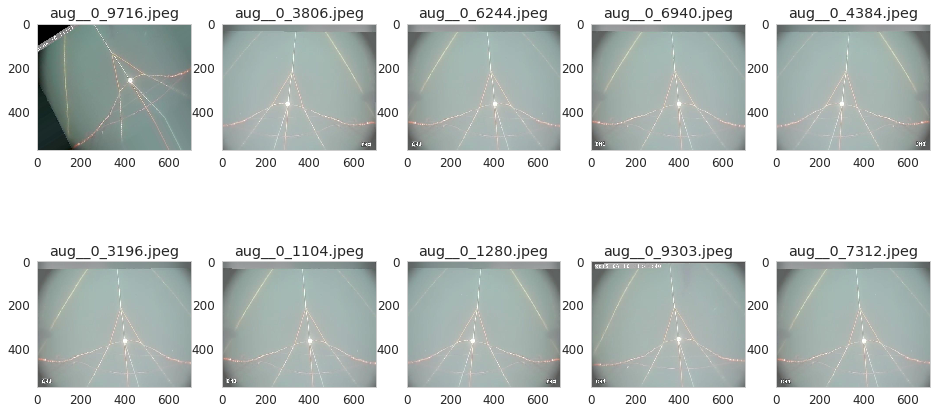

In [264]:
img = load_img(path_data_train + 'seal/' + os.listdir(path_data_train + '/seal/')[20])
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen_train.flow(x, batch_size=1,save_to_dir=path_preview, save_prefix='aug_', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
# view augmented preview images
plot_pic_grid(path_preview, os.listdir(path_preview)[:10])

## setup batches

In [265]:
train_batches = train_gen.flow_from_directory(
    path_data_train,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    class_mode='binary'
)

valid_batches = test_gen.flow_from_directory(
    path_data_valid,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

test_batches = test_gen.flow_from_directory(
    path_data_test,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

Found 2351 images belonging to 2 classes.
Found 290 images belonging to 2 classes.
Found 1970 images belonging to 2 classes.


X shape:  (32, 3, 224, 224)
Y shape:  (32,)


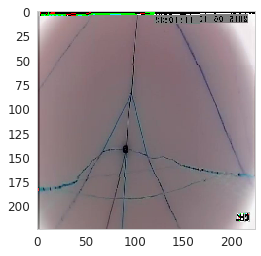

In [266]:
# view single image - distorted because removed imagenet means
temp_train_batch = train_batches.next()
print('X shape: ', temp_train_batch[0].shape)
print('Y shape: ', temp_train_batch[1].shape)

a = temp_train_batch[0][0]
a = np.rollaxis(a,2)
a = np.rollaxis(a,2)
plt.imshow(a)

## setup model

In [267]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Flatten
from keras.layers.pooling import GlobalMaxPool2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, Adadelta
from keras.callbacks import ModelCheckpoint

In [268]:
base_model = ResNet50(include_top=False, input_shape=(3, img_width, img_height))

In [269]:
ft_map = base_model.get_layer(index=-2).output

x = Conv2D(128, (3,3), padding='same')(ft_map)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
x = GlobalAveragePooling2D()(x)

model = Model(base_model.input, x)

In [270]:
# freeze all the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [271]:
# start with high learning rate
opt = Adam(0.001)
#
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## fit model

In [272]:
model_name = 'ResNet50'

In [273]:
# define keras model checkpointer to save best model (highets val_acc)
checkpointer = ModelCheckpoint(path_models + model_name + '_BEST_.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                save_weights_only=True)

In [275]:
model.load_weights(path_models + model_name + '_BEST_.hdf5')

In [278]:
history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=3,                    
                    verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

In [ ]:
plot_learning_curves(history) 

## update learning rate and train some more

In [ ]:
# reduce the learning rate
K.set_value(model.optimizer.lr, 0.0001)

# load weights from best epoch (saved by checkpointer)
model.load_weights(path_models + model_name + '_BEST_.hdf5')

history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=10,                    
                    verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

In [ ]:
plot_learning_curves(history)

## update learning rate and train some more

In [ ]:
# reduce the learning rate some more
K.set_value(model.optimizer.lr, 0.00001)

# load weights from best epoch (saved by checkpointer)
model.load_weights(path_models + model_name + '_BEST_.hdf5')

history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=10,                    
                    verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

In [ ]:
plot_learning_curves(history)

## update the learning rate and train some more

In [ ]:
# reduce the learning rate some more
K.set_value(model.optimizer.lr, 0.000001)

# load weights from best epoch (saved by checkpointer)
model.load_weights(path_models + model_name + '_BEST_.hdf5')

history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=3,                    
                    verbose=1, 
                    validation_data=valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

## load best rates and check performance

In [ ]:
# load weights from best epoch (saved by checkpointer)
model.load_weights(path_models + model_name + '_BEST_.hdf5')

In [ ]:
print (model.metrics_names)
model.evaluate_generator(valid_batches, np.ceil(valid_batches.samples/batch_size))